# Stochastic volatility
This Notebook demos how to construct a stochastic volatility model and fit it to data. We will use the precision model of G. Chacko and L. M. Viceira. `Dynamic consumption and portfolio choice with stochastic volatility in incomplete markets` given by
\begin{cases}
Y_t = \mu + \beta e^{-V_t} + e^{-V_t/2} W_t, \\
\mathrm{d}V_t = \kappa \left (\gamma - V_t \right ) \mathrm{d}t + \sigma \mathrm{d}B_t, \\
\end{cases}
where $\mu, \beta, \gamma \in \mathbb{R}$, and $\kappa, \sigma \in \mathbb{R}_+$.$\{V_t\}$ is a one-dimensional Wiener processes, wheras $\{W_t\}$ is assumed to follow a central Student's $t$ distribution with $\nu$ degrees of freedom. 

We begin with importing the necessary libraries for defining the model.

In [1]:
%cd .. 
from pyfilter.timeseries import StateSpaceModel, OrnsteinUhlenbeck, Observable, Parameter

/Users/victortingstrom/Documents/GitHub/pyfilter


Next, we define the governing dynamics

In [2]:
import torch

def go(vol, level, beta):
    return level + beta * torch.exp(-vol)


def fo(vol, level, beta):
    return torch.exp(-vol / 2)

Next, we shall define our model. In order to do so, we must specify priors for the different parameters. Given their support, we assume that
\begin{cases}
    \gamma \sim \mathcal{N}(0, 1), \\
    \mu, \beta \sim \mathcal{N}(0, 0.5), \\
    \kappa \sim \mathcal{E}(10), \\
    \sigma \sim \mathcal{E}(5), \\
    \nu \sim \mathcal{E}(0.1).
\end{cases}
To do this, we need to import the necessary distributions.

In [3]:
from torch.distributions import Exponential, Normal, StudentT

Next, we define the model in terms of code and get

In [4]:
logvol = OrnsteinUhlenbeck(Exponential(10), Normal(0., 0.5), Exponential(5), ndim=1, dt=1.)
obs = Observable((go, fo), (Normal(0., 0.5), Normal(0., 0.5)), StudentT(Parameter(Exponential(0.1))))

stockmodel = StateSpaceModel(logvol, obs)

And that defines the model. Next, we need a dataset to train on. We're just going to pick the S&P500, note that this series is fetched using `pymc3=3.4`.

In [5]:
import numpy as np
import pandas as pd
import pymc3 as pm

y = pd.Series(np.genfromtxt(pm.get_data('SP500.csv'))) * 100

We plot the data to get an idea of its volatility

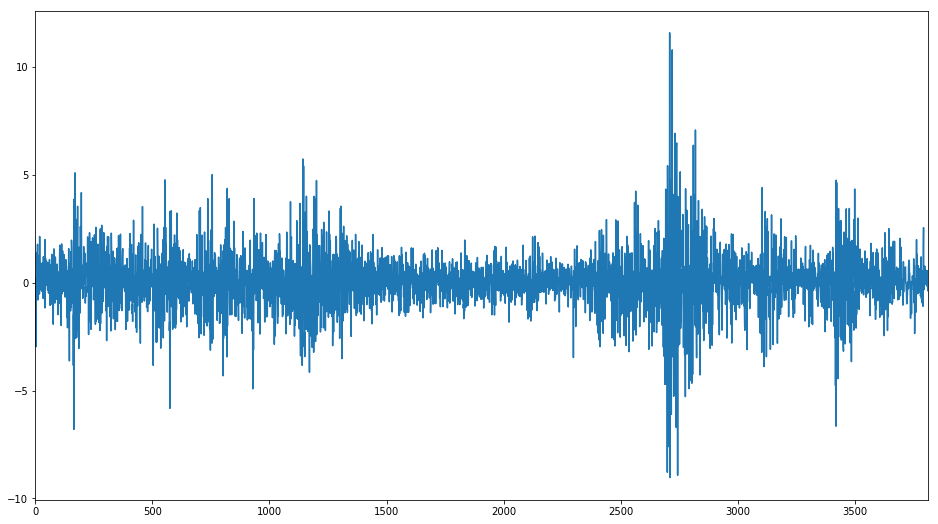

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))

y.plot(ax=ax)

In order to fit the model to the given data, we need an algorithm. We shall use a combination of NESS and SMC$^2$. We use SMC$^2$ for the first part of the data set, and then switch to NESS. Furthermore, since we are using particle filters, we need to decide on which proposal to use - should we go with the Bootstrap or something more advanced? For this example, we will use a Bootstrap version. Importing the relevant classes, we get

In [7]:
from pyfilter.algorithms import NESSMC2
from pyfilter.filters import APF
from pyfilter.proposals import Linearized

Let's now fit the model to the data, but first moving it to the GPU (GTX 1070)

In [8]:
from pyfilter.resampling import multinomial

predictions = 10
training = torch.tensor(y.values, dtype=torch.float32)

algs = list()
for i in range(2):
    filt = APF(stockmodel.copy(), 250, resampling=multinomial)
    alg = NESSMC2(filt, 2000, smc2_threshold=0.2).initialize()
    
    alg.fit(training)
    
    algs.append(alg)

NESS: 100%|██████████| 3813/3813 [25:01<00:00,  3.36it/s]                             


Next, we plot the posterior distributions. The first three correspond to the reversion, mean and standard deviation of the latent process. The last three correspond to the level, exposure to volatility and dof of the observable model. Comparing $\nu$ to the posterior of [PyMC3](https://docs.pymc.io/notebooks/stochastic_volatility.html), we see that they are rather similar.

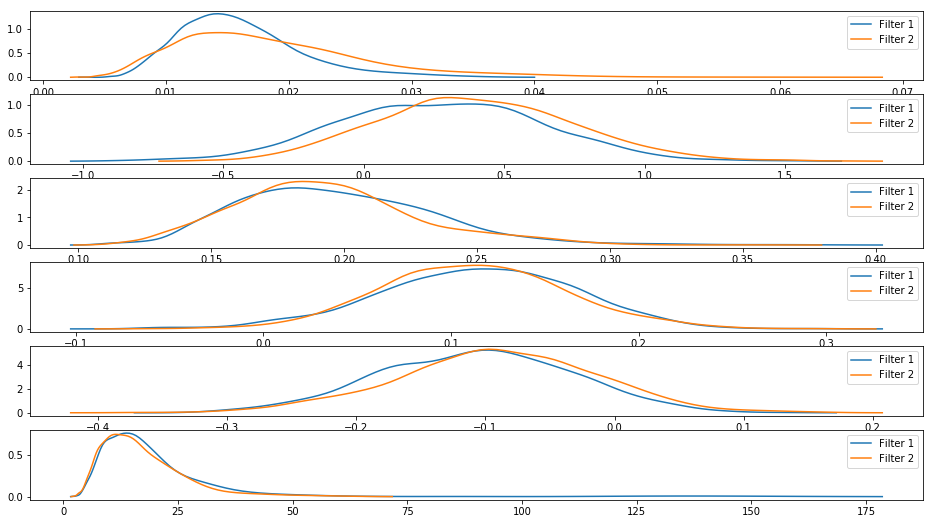

In [9]:
from pyfilter.utils import normalize
import pandas as pd

fig, ax = plt.subplots(len(alg.filter.ssm.flat_theta_dists), figsize=(16, 9))
for r, alg in enumerate(algs):
    w = normalize(alg._ness._w_rec)

    for i, param in enumerate(alg.filter.ssm.flat_theta_dists):    
        xrange, xvals = param.get_plottable(weights=w)

        mean = (w * param).sum()
        std = (w * (param - mean) ** 2).sum().sqrt()
        
        ax[i].plot(xrange, xvals, label='Filter {:d}'.format(r+1))

        ax[i].legend()

Let's plot a crude estimate of the underlying volatility. I say crude here because we uniformly weight the trajectories.

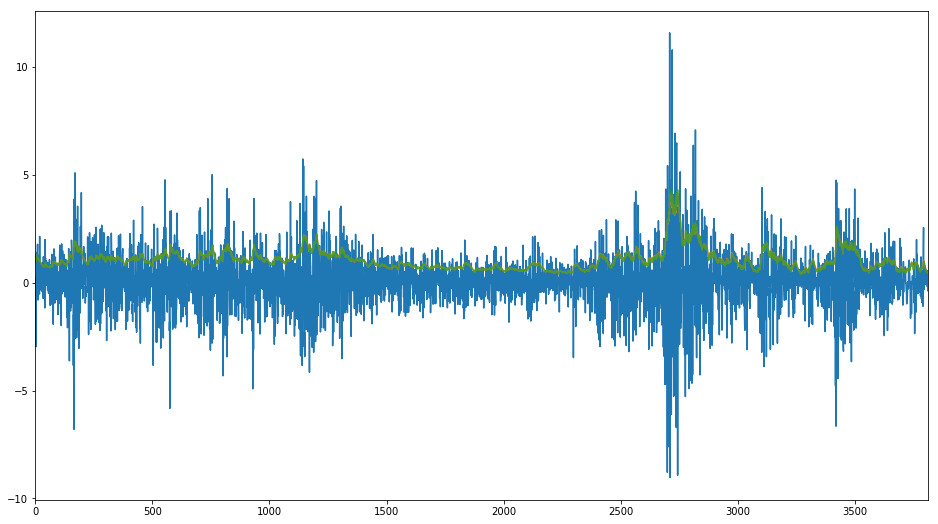

In [10]:
fig, ax = plt.subplots(figsize=(16, 9))
y.iloc[:training.shape[0]].plot(ax=ax)

for alg in algs:
    asdf = pd.DataFrame((-alg.filter.filtermeans / 2).exp().cpu().numpy(), index=y.index[:training.shape[0]])

    asdf.mean(1).plot(alpha=0.75, ax=ax)

A plot over the ESS.

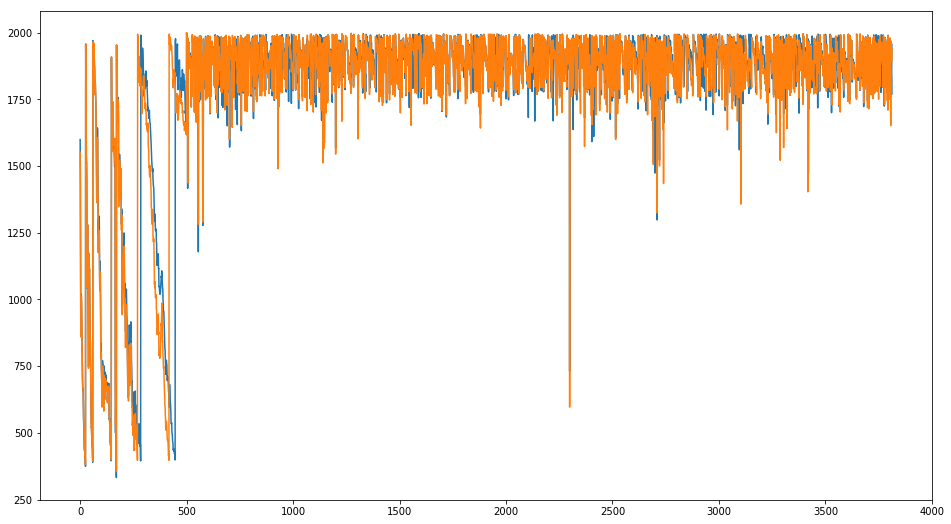

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))
for alg in algs:
    ax.plot(alg.logged_ess.cpu().numpy())

And finally, a plot of the loglikelihood distribution 

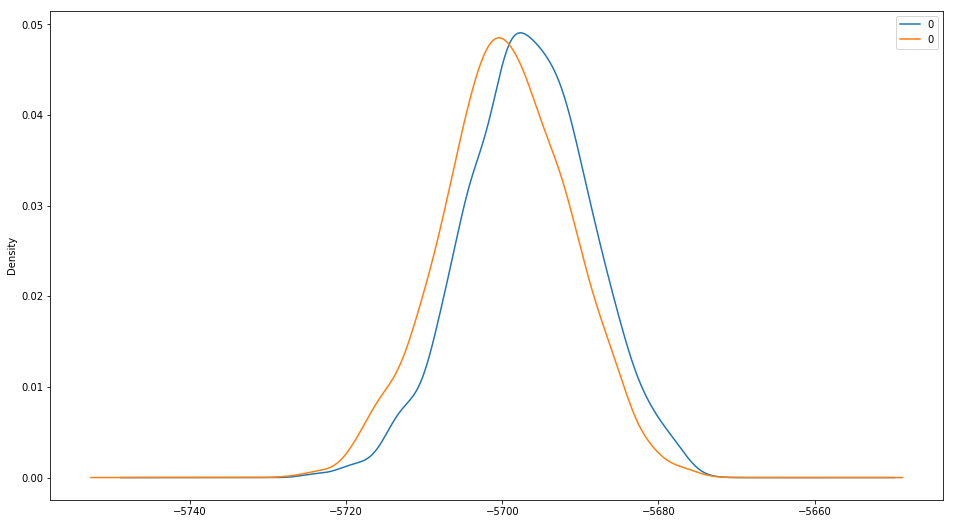

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))

for alg in algs:
    pd.DataFrame(alg.filter.loglikelihood.cpu().numpy()).plot.kde(ax=ax)